In [31]:
from rdflib import Graph, RDF, URIRef, Namespace
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
%matplotlib inline
import rdfextras
rdfextras.registerplugins()
import matplotlib_venn as mv

In [32]:
g = Graph()
g.parse("../graph/experiment_graph.ttl", format="turtle")
foaf = Namespace("http://xmlns.com/foaf/0.1/")
localNS = Namespace("http://deepweb.ut.ee/ontologies/api-network#")

In [33]:
ns = dict(api_network=localNS, cat= Namespace("http://www.programmableweb.com/category/"), 
          rdf = RDF, gr = Namespace("http://purl.org/goodrelations/v1#"), pw_api = Namespace("http://www.programmableweb.com/api/") )

#Basic counts#

In [34]:
#basic counts
rows = g.query("""SELECT DISTINCT ?c WHERE {
                ?s api_network:primaryCategory|api_network:secondaryCategory ?c .}""" , initNs=ns)
categories = len(rows)
num_of_triplets = (len(g))
num_of_apis = (len(list(g.subjects(RDF.type, localNS.API))))
num_of_users = (len(list(g.subjects(RDF.type, foaf.OnlineAccount))))
num_of_mashups = (len(list(g.subjects(RDF.type, localNS.Mashup))))
table = Series([num_of_triplets, num_of_apis, num_of_users, num_of_mashups, categories], 
               index = ["Number of triples","Number of APIs", "Number of Users", "Number of Mashups", "Number of categories"])
print(table)

Number of triples       497734
Number of APIs           14028
Number of Users          70328
Number of Mashups         7692
Number of categories       461
dtype: int64


#Popularity of top 5 categories#

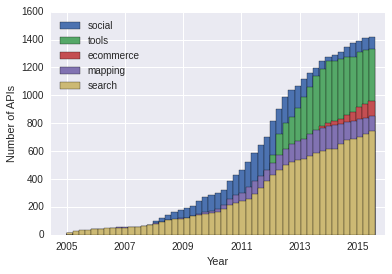

In [5]:
def get_data_by_category(category):
    rows = g.query("""SELECT ?s ?d WHERE {?s ?p api_network:API .
                                        ?s api_network:registrationDate ?d . 
                                        ?s api_network:primaryCategory|api_network:secondaryCategory cat:%s .}""" % category, initNs=ns)
    #print(len([t["?s"] for t in rows.bindings]))
    dates = [t["?d"] for t in rows.bindings]
    return [r.toPython() for r in dates]
categories = ["search", "mapping", "tools", "social", "ecommerce"]
dict_of_dates = {}
for cat in categories:
    dict_of_dates[cat]=get_data_by_category(cat)
#for key in dict_of_dates:
#    plt.hist(date2num(dict_of_dates[key]), cumulative=True, bins = 50, label = key)
plt.hist(date2num(dict_of_dates["social"]), cumulative=True, bins = 50, label = "social")
plt.hist(date2num(dict_of_dates["tools"]), cumulative=True, bins = 50, label = "tools")
plt.hist(date2num(dict_of_dates["ecommerce"]), cumulative=True, bins = 50, label = "ecommerce")
plt.hist(date2num(dict_of_dates["mapping"]), cumulative=True, bins = 50, label = "mapping")
plt.hist(date2num(dict_of_dates["search"]), cumulative=True, bins = 50, label = "search")

plt.legend(loc=2)
x=date2num(dict_of_dates["mapping"])
plt.xticks(np.arange(min(x), max(x)+1, (max(x)+1 - min(x))/5.3), ["2005", "2007", "2009", "2011", "2013", "2015"])
plt.xlabel("Year")
plt.ylabel("Number of APIs")
#def plot_kd(list_of_dates):
#    s = Series(date2num(list_of_dates))
#    xcol, ycol = sns.kdeplot(s, color = "w").get_lines().pop().get_data()
#    ycol=np.cumsum(ycol)
#    line, = plt.plot(xcol,ycol)
#    return line

#Communication protocols#

In [6]:
rows = g.query("""SELECT DISTINCT ?p WHERE {?s rdf:type api_network:API .
                                    ?s api_network:protocol ?p .}""", initNs=ns)
protocols = [p["?p"].toPython() for p in rows.bindings]
protocols[:15]

['REST',
 'XML',
 'SOAP',
 'JavaScript',
 'JSON',
 'HTTP',
 'JSONP',
 'JSON-RPC',
 'YAML',
 'EPP',
 'HTTP POST, JavaScript',
 'JOSN',
 'SMPP',
 'Javascript',
 'RSS']

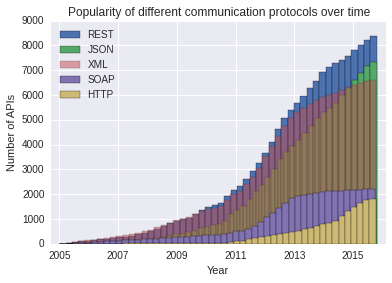

In [7]:
def get_dates_by_protocol(protocol):
    rows = g.query(""" SELECT ?d WHERE { ?s rdf:type api_network:API .
                        ?s api_network:registrationDate ?d .
                        ?s api_network:protocol "%s" . } """ % protocol, initNs = ns)
    dates = [t["?d"] for t in rows.bindings]
    return [r.toPython() for r in dates]
rest_dates = get_dates_by_protocol("REST")
soap_dates = get_dates_by_protocol("SOAP")
json_dates = get_dates_by_protocol("JSON")
http_dates = get_dates_by_protocol("HTTP")
xml_dates = get_dates_by_protocol("XML")
x = date2num(rest_dates)
plt.hist(date2num(rest_dates), cumulative=True, bins = 50, label = "REST")
plt.hist(date2num(json_dates), cumulative=True, bins = 50, label = "JSON")
plt.hist(date2num(xml_dates), cumulative=True, bins = 50, label = "XML", alpha=0.5)
plt.hist(date2num(soap_dates), cumulative=True, bins = 50, label = "SOAP")
plt.hist(date2num(http_dates), cumulative=True, bins = 50, label = "HTTP")
plt.xticks(np.arange(min(x), max(x)+1, (max(x)+1 - min(x))/5.4), ["2005", "2007", "2009", "2011", "2013", "2015"])
plt.legend(loc=2)
plt.xlabel("Year")
plt.ylabel("Number of APIs")
plt.title("Popularity of different communication protocols over time")

#Intersection of API categories#

In [29]:
def get_services_by_category(category):
    rows = g.query("""SELECT ?s WHERE {?s ?p api_network:API .
                ?s api_network:primaryCategory|api_network:secondaryCategory cat:%s .}""" % category, initNs=ns)
    return [t["?s"] for t in rows.bindings]

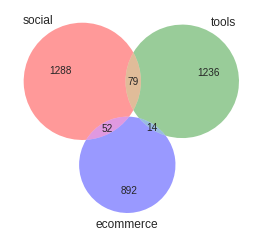

In [37]:
set1 = set(get_services_by_category("social"))
set2 = set(get_services_by_category("tools"))
set3 = set(get_services_by_category("ecommerce"))
mv.venn3([set1, set2, set3], ("social", "tools", "ecommerce"))

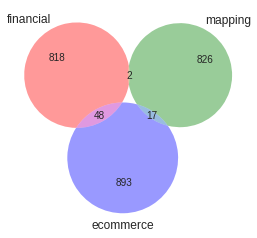

In [10]:
set1 = set(get_services_by_category("financial"))
set2 = set(get_services_by_category("mapping"))
set3 = set(get_services_by_category("ecommerce"))
mv.venn3([set1, set2, set3], ("financial", "mapping", "ecommerce"))

#Distribution of activation time#

In [11]:
rows = g.query("""SELECT ?s ?d ?d1 WHERE {?s rdf:type api_network:API .
                ?s api_network:registrationDate ?d .
                ?m rdf:type api_network:Mashup .
                ?m gr:include ?s .
                ?m api_network:registrationDate ?d1 .
                }""", initNs=ns)
service = [t["?s"] for t in rows.bindings]
dates = [t["?d"].toPython() for t in rows.bindings]
activation_date = [t["?d1"].toPython() for t in rows.bindings]
ad = [np.datetime64(f) for f in activation_date]
d = [np.datetime64(m) for m in dates]
data = {"Activation date" : ad,
       "Registration date" : d,       
       "Service" : service}
sf = DataFrame(data)
groups = sf.groupby("Service")

In [12]:
s = []
d = []
for gr in groups:
    reg_date = gr[1].iloc[[0]]["Registration date"]
    rd = list(reg_date.items())[0][1]
    g = gr[1]
    df_with_positif_diff = g[g["Activation date"]>rd]   
    try:
        arg_min = df_with_positif_diff["Activation date"].argmin()    
        diff = sf.iloc[[arg_min]]["Activation date"] - sf.iloc[[arg_min]]["Registration date"]
        s.append(gr[0])
        d.append(diff[arg_min])
    except:
        pass
delay_data = DataFrame({"Service":s, "Activation time":d})

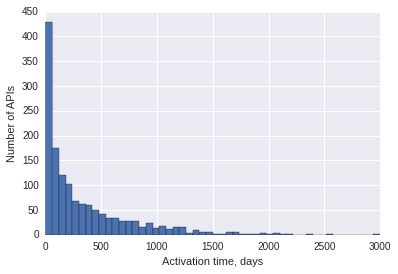

In [13]:
plt.hist((delay_data["Activation time"]).astype('timedelta64[D]'), bins=50)
plt.xlabel("Activation time, days")
plt.ylabel("Number of APIs")

In [27]:
#import pylab as pl
#pl.hist((delay_data["Activation time"]).astype('timedelta64[D]'), bins=np.linspace(5, 3000, 50)) #bins=np.logspace(0.1, 4, 50)
#pl.gca().set_xscale("log")
#pl.gca().set_yscale("log")
#pl.show()

#Distribution of num of APIs per Mashup#

In [38]:
rows = g.query("""SELECT ?m (COUNT(?s) as ?apiCount) WHERE {
                ?s ?p api_network:API .
                ?m ?p api_network:Mashup .
                ?m gr:include ?s .
                }
                GROUP BY ?m""", initNs=ns)

In [55]:
api_count_frame = DataFrame()
api_count_frame["Mashup"] = [t["?m"].toPython() for t in rows.bindings]
api_count_frame["API COUNT"] = [t["?apiCount"].toPython() for t in rows.bindings]
#api_count_frame[api_count_frame["API COUNT"]>29]
#plt.hist(api_count_frame["API COUNT"])

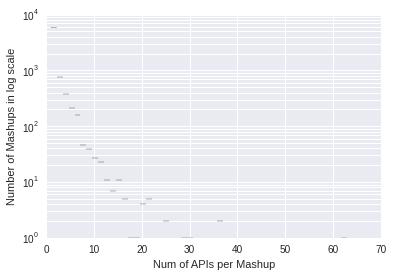

In [59]:
import pylab as pl
pl.hist(api_count_frame["API COUNT"], bins = 50, facecolor = "black")
pl.gca().set_yscale("log")
#pl.Figure.set_edgecolor("black")
pl.xlabel("Num of APIs per Mashup")
pl.ylabel("Number of Mashups in log scale")
pl.show()

#Functionality diffusion matrix between top 15 categories#

In [61]:
# select most popular categories
def count_popular_categories():
    r = g.query("""SELECT ?c (COUNT(?c) as ?catCount) WHERE  {
                    ?s api_network:primaryCategory|api_network:secondaryCategory ?c .
                    }
                    GROUP BY ?c""", initNs=ns)
    frame = DataFrame()
    frame["Category"] = [t["?c"].toPython() for t in r.bindings]
    frame["Count"] = [t["?catCount"].toPython() for t in r.bindings]
    #frame = frame.sort("Count", ascending = 0)
    selected = frame[frame["Count"]>540]["Category"] #Series of top used categories
    return selected

In [62]:
selected = count_popular_categories()

In [63]:
# count number of transitions from given api category to given mashup category
def count_num_of_transitions(cat1, cat2):
    r = g.query("""SELECT ?s ?m WHERE { ?s ?p api_network:API .
                    ?m rdf:type api_network:Mashup .
                    ?m gr:include ?s .
                    ?s api_network:primaryCategory|api_network:secondaryCategory cat:%s. 
                    ?m api_network:tag cat:%s}""" % (cat1, cat2) , initNs=ns)
    return len(r)
count_num_of_transitions("mapping", "mapping")
#links = DataFrame()
#links["API"] = [t["?s"].toPython() for t in r.bindings]
#links["Mashup"] = [t["?m"].toPython() for t in r.bindings]

3508

In [75]:
diffusion_frame = DataFrame()
for api_cat in selected:
    for mashup_cat in selected:
        api_cat = api_cat.replace("http://www.programmableweb.com/category/", "")
        mashup_cat = mashup_cat.replace("http://www.programmableweb.com/category/", "")
        df = DataFrame([[api_cat, mashup_cat, count_num_of_transitions(api_cat, mashup_cat)]], columns = ["API Category", "Mashup Category", "Num of Transactions"])
        diffusion_frame = diffusion_frame.append(df, ignore_index=True)
        #count_num_of_transitions(api_cat.replace("http://www.programmableweb.com/category/", ""), mashup_cat.replace("http://www.programmableweb.com/category/", ""))        
        #print(api_cat.replace("http://www.programmableweb.com/category/", ""), mashup_cat.replace("http://www.programmableweb.com/category/", ""), "\n")

In [76]:
diffusion_frame_for_plotting = diffusion_frame.pivot("API Category", "Mashup Category", "Num of Transactions")
diffusion_frame_for_plotting

Mashup Category,data,ecommerce,enterprise,financial,government,mapping,marketing,messaging,mobile,payments,reference,search,social,telephony,tools
API Category,,,,,,,,,,,,,,,
data,11,3,0,1,0,18,1,2,1,0,4,21,13,1,3
ecommerce,3,897,2,10,2,187,4,34,43,21,69,368,156,12,27
enterprise,2,18,61,8,1,26,9,15,10,0,12,38,64,6,24
financial,0,23,8,35,3,11,4,8,7,20,9,23,16,6,7
government,7,4,3,19,79,48,5,4,7,0,15,9,9,4,4
mapping,17,217,21,28,121,3508,6,77,126,0,238,456,433,35,100
marketing,0,8,1,0,0,4,6,16,5,0,7,6,9,4,12
messaging,1,30,5,10,2,32,4,314,224,3,28,45,97,111,20
mobile,1,25,3,9,3,138,1,105,157,1,23,84,146,15,21


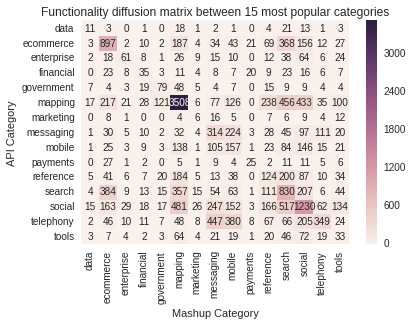

In [77]:
ax = plt.axes()
sns.heatmap(diffusion_frame_for_plotting, annot=True, fmt='d') #, center = diffusion_frame.loc["reference", "reference"]
ax.set_title('Functionality diffusion matrix between 15 most popular categories')
plt.show()